In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
import random
import time

2024-11-21 17:20:05.713857: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 17:20:05.950187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 17:20:07.126970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def reward_function(action, current_price, cash, stocks_held):
    transaction_fee = 0  # Set transaction fee if needed
    if action == 0:  # Buy
        if cash >= (current_price + transaction_fee):
            num_stocks = (cash - transaction_fee) / current_price
            total_cost = num_stocks * current_price + transaction_fee
            stocks_held += num_stocks
            cash -= total_cost
            reward = 0  # No immediate reward for buying
        else:
            reward = -100  # Penalty for insufficient cash
    elif action == 1:  # Sell
        if stocks_held > 0:
            total_value = stocks_held * current_price
            profit = total_value - transaction_fee
            cash += profit
            stocks_held = 0
            reward = profit  # Reward is the profit from selling
        else:
            reward = -100  # Penalty for no stocks to sell
    elif action == 2:  # Hold
        reward = 0  # Neutral reward for holding
    else:
        reward = 0  # Default reward
    return reward, cash, stocks_held

def update_state(time_step, data, cash, stocks_held ):
    """Update the state vector with market data and raw agent-specific features."""
    # Extract market features for the current time step
    market_features = data.iloc[time_step][[
        'Close/Last', 'Open', 'High', 'Low', 'Volume',
        'Returns', 'SMA-5', 'SMA-20', 'Volatility', 'MACD'
    ]].values.tolist()

    # Use raw agent-specific features
    agent_features = [cash, stocks_held]  # Directly append raw cash and stocks_held values

    # Combine market and agent features into a single state
    state = market_features + agent_features
    state = np.array(state, dtype=np.float32)
    return state

# Neural network model for approximating Q-values
def build_model(state_size, action_size):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(state_size,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')
    return model

def select_action_dqn(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return np.random.choice(range(action_size))  # Explore
    else:
        state_array = np.array(state, dtype=np.float32)
        q_values = main_model.predict(state_array[np.newaxis, :])  # Shape (1, state_size)
        return np.argmax(q_values[0])  # Exploit

def store_experience(state, action, reward, next_state, done):
    state_array = np.array(state, dtype=np.float32)
    next_state_array = np.array(next_state, dtype=np.float32)
    memory.append((state_array, action, reward, next_state_array, done))

def sample_experiences(batch_size):
    return random.sample(memory, batch_size)

# List of Companies
companies = ['AMD', 'AMZN', 'CSCO', 'META', 'MSFT', 'NFLX', 'QCOM', 'SBUX', 'TSLA']

# Data Loading and Preprocessing Function
def load_and_preprocess_data(company):
    data = pd.read_csv(f'company_datasets/{company}_data.csv')
    data = data.iloc[::-1].reset_index(drop=True)  # Earliest to latest
    data['EMA-12'] = data['Close/Last'].ewm(span=12, adjust=False).mean()
    data['EMA-26'] = data['Close/Last'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA-12'] - data['EMA-26']
    data['Returns'] = data['Close/Last'].pct_change()
    data['SMA-5'] = data['Close/Last'].rolling(window=5).mean()
    data['SMA-20'] = data['Close/Last'].rolling(window=20).mean()
    data['Volatility'] = data['Returns'].rolling(window=5).std()
    data = data.dropna()
    return data

In [7]:
# Load Data for All Companies
company_data = {company: load_and_preprocess_data(company) for company in companies}

cash_initial = 1000  # Initial cash available
stocks_held_initial = 0  # Initial stocks held
transaction_fee = 0

# Define action space
actions = [0, 1, 2]  # 0 = Buy, 1 = Sell, 2 = Hold

# Define hyperparameters
state_size = 12  # Length of your feature vector
action_size = 3  # Number of possible actions
learning_rate = 0.001
discount_factor = 0.9
batch_size = 32
episodes = 100
exploration_rate = 0.95  # Initial exploration rate
exploration_decay = 0.95
exploration_min = 0.01
memory_size = 10000  # Replay buffer 
train_frequency = 10  # Train every 10 steps

# Initialize the main and target networks
main_model = build_model(state_size, action_size)
target_model = build_model(state_size, action_size)
target_model.set_weights(main_model.get_weights())

# Experience replay buffer
memory = deque(maxlen=memory_size)

total_profits = []

# Training Loop
for episode in range(episodes):
    episode_start_time = time.time()
    print(f"Starting Episode {episode + 1}/{episodes}")

    for company in companies:
        data = company_data[company]
        cash = cash_initial
        stocks_held = stocks_held_initial
        state = update_state(0, data, cash, stocks_held)
        total_reward = 0

        for t in range(len(data) - 1):
            # Select an action
            action = select_action_dqn(state, exploration_rate)

            # Perform the action
            reward, cash, stocks_held = reward_function(action, data.iloc[t]['Close/Last'], cash, stocks_held)
            next_state = update_state(t + 1, data, cash, stocks_held)
            done = (t == len(data) - 2)  # Check if it's the last time step

            # Store the experience
            store_experience(state, action, reward, next_state, done)

            # Update the state
            state = next_state
            total_reward += reward

            # Train the model at specified intervals
            if len(memory) >= batch_size and t % train_frequency == 0:
                batch = sample_experiences(batch_size)
                states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = zip(*batch)
                states_batch = np.array(states_batch, dtype=np.float32)
                next_states_batch = np.array(next_states_batch, dtype=np.float32)
                rewards_batch = np.array(rewards_batch, dtype=np.float32)
                dones_batch = np.array(dones_batch, dtype=np.float32)

                # Predict Q-values for next states using the target model
                next_q_values = target_model.predict(next_states_batch, verbose=0)
                max_next_q_values = np.max(next_q_values, axis=1)

                # Compute target Q-values
                targets = rewards_batch + discount_factor * (1 - dones_batch) * max_next_q_values

                # Predict Q-values for current states
                q_values = main_model.predict(states_batch, verbose=0)

                # Update Q-values for selected actions
                for i in range(len(batch)):
                    q_values[i, actions_batch[i]] = targets[i]

                # Train the main model
                main_model.fit(states_batch, q_values, verbose=0, epochs=1)

        # Reduce exploration rate after each company
        exploration_rate = max(exploration_rate * exploration_decay, exploration_min)

        # Update the target network periodically
        target_model.set_weights(main_model.get_weights())

        # Calculate Profit for the Company
        final_price = data.iloc[-1]['Close/Last']
        net_worth = cash + stocks_held * final_price
        profit = net_worth - cash_initial
        total_profits.append(profit)
        print(f"Company: {company}, Episode {episode + 1}/{episodes}, Profit: {profit}")
    main_model.save('trained_dqn_model.h5')
    print(f"Episode {episode + 1}/{episodes} completed in {time.time() - episode_start_time:.2f} seconds")

# Optionally, save the model after training
main_model.save('trained_dqn_model.h5')


1/1 [==============================] - 5s 5s/step


: 

In [ ]:
# Run this if crash:
# Load Data for All Companies
company_data = {company: load_and_preprocess_data(company) for company in companies}

cash_initial = 1000  # Initial cash available
stocks_held_initial = 0  # Initial stocks held
transaction_fee = 0

# Define action space
actions = [0, 1, 2]  # 0 = Buy, 1 = Sell, 2 = Hold

# Define hyperparameters
state_size = 12  # Length of your feature vector
action_size = 3  # Number of possible actions
learning_rate = 0.001
discount_factor = 0.9
batch_size = 128
episodes = 1000
exploration_rate = 0.3  # Initial exploration rate
exploration_decay = 0.9
exploration_min = 0.01
memory_size = 10000  # Replay buffer 
train_frequency = 10  # Train every 10 steps

# **Load the previously saved main model**
try:
    # Attempt to load the model with compile=False
    main_model = tf.keras.models.load_model('trained_dqn_model.h5', compile=False)
except ValueError as e:
    print(f"Error loading model: {e}")
    # If loading fails, rebuild the model architecture and load weights
    main_model = build_model(state_size, action_size)
    main_model.load_weights('trained_dqn_model.h5')

target_model = build_model(state_size, action_size)
target_model.set_weights(main_model.get_weights())

# Experience replay buffer
memory = deque(maxlen=memory_size)

total_profits = []

# Training Loop
for episode in range(episodes):
    episode_start_time = time.time()
    print(f"Starting Episode {episode + 1}/{episodes}")

    for company in companies:
        data = company_data[company]
        cash = cash_initial
        stocks_held = stocks_held_initial
        state = update_state(0, data, cash, stocks_held)
        total_reward = 0

        for t in range(len(data) - 1):
            # Select an action
            action = select_action_dqn(state, exploration_rate)

            # Perform the action
            reward, cash, stocks_held = reward_function(action, data.iloc[t]['Close/Last'], cash, stocks_held)
            next_state = update_state(t + 1, data, cash, stocks_held)
            done = (t == len(data) - 2)  # Check if it's the last time step

            # Store the experience
            store_experience(state, action, reward, next_state, done)

            # Update the state
            state = next_state
            total_reward += reward

            # Train the model at specified intervals
            if len(memory) >= batch_size and t % train_frequency == 0:
                batch = sample_experiences(batch_size)
                states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = zip(*batch)
                states_batch = np.array(states_batch, dtype=np.float32)
                next_states_batch = np.array(next_states_batch, dtype=np.float32)
                rewards_batch = np.array(rewards_batch, dtype=np.float32)
                dones_batch = np.array(dones_batch, dtype=np.float32)

                # Predict Q-values for next states using the target model
                next_q_values = target_model.predict(next_states_batch, verbose=0)
                max_next_q_values = np.max(next_q_values, axis=1)

                # Compute target Q-values
                targets = rewards_batch + discount_factor * (1 - dones_batch) * max_next_q_values

                # Predict Q-values for current states
                q_values = main_model.predict(states_batch, verbose=0)

                # Update Q-values for selected actions
                for i in range(len(batch)):
                    q_values[i, actions_batch[i]] = targets[i]

                # Train the main model
                main_model.fit(states_batch, q_values, verbose=0, epochs=1)

        # Reduce exploration rate after each company
        exploration_rate = max(exploration_rate * exploration_decay, exploration_min)

        # Update the target network periodically
        if episode % 5 == 0:
            target_model.set_weights(main_model.get_weights())

        # Calculate Profit for the Company
        final_price = data.iloc[-1]['Close/Last']
        net_worth = cash + stocks_held * final_price
        profit = net_worth - cash_initial
        total_profits.append(profit)
        print(f"Company: {company}, Episode {episode + 1}/{episodes}, Profit: {profit}")
    main_model.save('trained_dqn_model2.h5')
    print(f"Episode {episode + 1}/{episodes} completed in {time.time() - episode_start_time:.2f} seconds")

# Optionally, save the model after training
main_model.save('trained_dqn_model2.h5')

In [5]:
# TEST 1
# Load test data
test_data = load_and_preprocess_data('AAPL')

# Load trained model
main_model = tf.keras.models.load_model('trained_dqn_model.h5', compile=False)

# Initialize state params
cash_init = 1000
stocks_held_init = 0
state_size = 12
action_size = 3

test_episodes = 100
test_profits1 = []

for episode in range(test_episodes):
    cash = cash_init
    stocks_held = stocks_held_init
    state = update_state(0, test_data, cash, stocks_held)
    total_reward = 0

    for t in range(len(test_data) - 1):
        action = select_action_dqn(state, 0)  # Greedy action
        reward, cash, stocks_held = reward_function(action, test_data.iloc[t]['Close/Last'], cash, stocks_held)
        next_state = update_state(t + 1, test_data, cash, stocks_held)
        state = next_state
        total_reward += reward

    final_price = test_data.iloc[-1]['Close/Last']
    net_worth = cash + stocks_held * final_price
    profit = net_worth - cash_init
    test_profits1.append(profit)
    print(f"Episode {episode + 1}/{test_episodes}, Profit: {profit}")

1/1 [==============================] - 3s 3s/step


KeyboardInterrupt: 

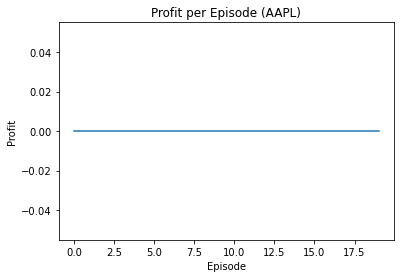

: 

In [ ]:
plt.plot(test_profits1)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (AAPL)')
plt.show()